# iRobot - Data Science Fall Internship, Coding Challenge

### Xingchen Wang
### Jul 31 - Aug 5, 2020

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
mission = pd.read_csv('mission_data.csv')
geo = pd.read_csv('geo_data.csv')

In [144]:
mission.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl


In [145]:
mission.shape

(367679, 7)

In [146]:
geo.head()

,country_cd,timezone,robotid
0,SE,Europe/Stockholm,T29NF13ZIYISNF79
1,JP,Asia/Tokyo,9S12V26O6G426OYR
2,IL,Asia/Jerusalem,QI6X3P9JKNILKKU1
3,IL,Asia/Jerusalem,7OMKNWMWA4XWC911
4,IL,Asia/Jerusalem,YO63CL0ZFK83SYCZ


In [147]:
# To make sure the geo table contains a sample of 10000 wifi-connected robots:
print(geo.shape)
print(geo['robotid'].nunique())

(10000, 3)
10000


Check how many robots are in the <b>mission</b> table:

In [148]:
# The table shounld have contained a sample of 10,000 wifi-connected robots
# While it is actually 9826
mission['robotid'].nunique()

9826

In [149]:
# No missing value exists in the mission table:
mission.isna().sum()

robotid     0
datetime    0
nmssn       0
runm        0
chrgm       0
pausem      0
outcome     0
dtype: int64

So 9826 unique robot id's indicates that some robots with their activities are not recorded in the sample dataset. <b>It means We have 174 robots with no data input, which may be due to that they are not connected to wifi, or not in use, etc </b>.

In [150]:
prob = (10000-9826)/10000
print('The proportion of robots that were not recorded:',f"{prob:.2%}")

The proportion of robots that were not recorded: 1.74%


In [151]:
# 2 NA's exists in the geo table. 2 country codes of the robots are not recorded:
geo.isna().sum()

country_cd    2
timezone      0
robotid       0
dtype: int64

In [152]:
# Show the info of the robots with missing country codes:
geo[geo.isna().any(axis=1)]

,country_cd,timezone,robotid
6091,NaN,Europe/Vaduz,QMJXZLREE88GULA1
6363,NaN,Africa/Windhoek,Z9JJM7JRIGJYLER2


So <b>other than the 174 missing robots info, we have two robots with time zones recorded but we are unsure about which country they are from</b>.

In [153]:
# Take a look at the summary information of the mission table
mission.describe()

,nmssn,runm,chrgm,pausem
count,367679.000000,367679.000000,367679.000000,367679.000000
mean,73.258984,48.906383,5.152772,6.231351
std,35.749076,29.819507,8.364238,8.202553
min,1.000000,0.000000,0.000000,0.000000
25%,47.000000,27.000000,0.000000,0.000000
50%,71.000000,47.000000,0.000000,1.000000
75%,95.000000,70.000000,11.000000,12.000000
max,248.000000,144.000000,30.000000,40.000000


From the above summary table, we know that:
* The above four different features all have the distributions that are positively skewed.
* The recorded robots have done at least 1 mission, at most 248. Most of the robots have completed around 47 (25%) to 95(75%) missions.
* The cleaning time is approximately 4 times as much as of the charging time and paused time. The minimum time spent from these 3 activities are all 0 minutes. The robots tended to encounter longer paused time than charging time by looking at the quantiles. 
* The paused time never reaches 90 minutes.

ok       190137
cncl     146615
stuck     22241
bat        8686
Name: outcome, dtype: int64


<AxesSubplot:>

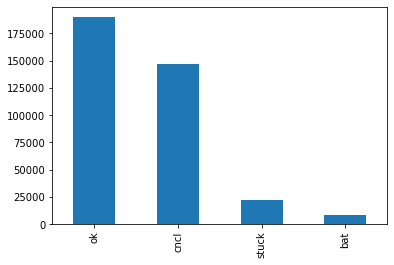

In [160]:
# To see how the outcome of the missions varies:
print(mission['outcome'].value_counts())
mission['outcome'].value_counts().plot(kind='bar')

We found that:
* most of the robots successfully completed cleaning the space and returned to the dock.
* A little less robots got mission cancelled.
* The robots got stuck fewer times (~20000 times).
* The least ocurring status is that the battery grew too low for the robot to return to the dock.

In [161]:
# See how many countries and time zones are those robots from:
print('# countries:', geo['country_cd'].nunique())
print('# time zones:', geo['timezone'].nunique())

# countries: 84
# time zones: 122


Since # time zones is larger than countries, sometimes we can also use countries as a key when exploring the geographic differences.

*** 
Moving on to reorganize the two tables so that we obtain the country info of each robot:

Merge the <b>mission</b> table and <b>geo</b> table based on "robotid" column, so we could rearrange the new table group by country. Noted that the column "robotid" in <b>geo</b> able is the primary key, which is also a common column that exists from both tables. We want to join the tables using "robotid" as a key:

In [162]:
robot = pd.merge(mission, geo)
robot.head()

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
0,000NG2FMLJBT9ANZ,2017-10-01 16:17:22,40,3,1,2,stuck,IL,Asia/Jerusalem
1,000NG2FMLJBT9ANZ,2017-10-03 14:25:56,41,83,0,13,ok,IL,Asia/Jerusalem
2,000NG2FMLJBT9ANZ,2017-10-04 12:32:51,42,66,13,12,ok,IL,Asia/Jerusalem
3,000NG2FMLJBT9ANZ,2017-10-26 02:12:55,45,72,24,0,cncl,IL,Asia/Jerusalem
4,000NG2FMLJBT9ANZ,2017-10-27 07:17:39,46,61,9,0,cncl,IL,Asia/Jerusalem


In [163]:
# Below shows the merged table group by timezone in descending order:
# the # of robots is saved in the "unique" column
tz = robot.groupby('timezone')['robotid'].describe().sort_values(by =['unique'],ascending=False)
tz.head()

,count,unique,top,freq
timezone,,,,
Asia/Jerusalem,221830,5998,WZ7X75SA8S96R7BW,163
Asia/Shanghai,21054,539,T565DZNSAY69JJMX,140
Europe/Paris,17814,481,GKJCCF6WZWEH1S3J,124
Asia/Tokyo,11584,290,PKT6LJQJ4371N9N6,133
Europe/Vienna,10544,283,D00L55IAMODI05ZA,123


Text(0, 0.5, 'Density')

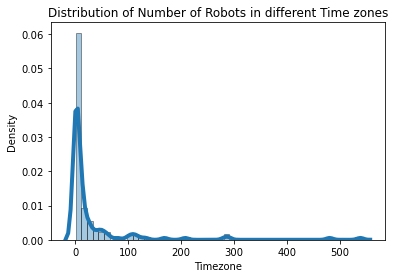

In [164]:
# Let's take a look at the distribution of number of robots in different time zones: 
# Eliminate the first row since the number is way larger than others - we may only see a peak without eliminating it.

#plt.plot(tz.index.values, tz['unique'])
import seaborn as sns
sns.distplot(tz.iloc[1:,:]['unique'], hist=True, kde=True, hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 4})
plt.title('Distribution of Number of Robots in different Time zones')
plt.xlabel('Timezone')
plt.ylabel('Density')

Seems like most of the time zones don't have so many robots in their regions. Most of the time zone regions have a smaller robotic vacuum cleaner market. It could be that either iRobot hasn't expand its business in many regions internationally as much as those places that have a well developed market, or people in some regions aren't so into using robotic vacuum cleaners yet - reasons may include socioeconomic status, lack of exposure to robotic vacuum cleaner commercials, etc.  

*** 
Next, I want to explore the difference of robot usage among geographic regions:

In [165]:
rb_count = robot[['runm', 'chrgm', 'pausem', 'outcome','country_cd', 'robotid']].groupby(['country_cd','robotid']).agg(['mean', 'count'])
rb_count = rb_count.reset_index()
rb_count.head()

country_cd           robotid       runm           chrgm          pausem  \
                                     mean count      mean count      mean   
0         AD  NABAHPPWEMFF0M8L  40.020000    50  1.500000    50  2.000000   
1         AE  692TO0M9H7UR94NO  55.000000    11  3.272727    11  3.636364   
2         AE  GAGDL6XHAVPPBRPI  44.489796    49  2.020408    49  4.183673   
3         AE  I29OEHIUM3R7LDWX  51.442308    52  1.615385    52  3.788462   
4         AE  RWS8L9TPNWB6U4C6  55.950000    20  3.700000    20  3.850000   

         
  count  
0    50  
1    11  
2    49  
3    52  
4    20

By looking at the table above, we get the sense that customers used the robots to a different extent since the average values of cleaning time, charging time, and paused time are different.

In [166]:
rb = pd.DataFrame()
rb['country_cd'] = rb_count['country_cd']
rb['robotid'] = rb_count['robotid']
rb['runm_mean'] = rb_count['runm']['mean']
rb['chrgm_mean'] = rb_count['chrgm']['mean']
rb['pausem_mean'] = rb_count['pausem']['mean']
rb.head()

,country_cd,robotid,runm_mean,chrgm_mean,pausem_mean
0,AD,NABAHPPWEMFF0M8L,40.020000,1.500000,2.000000
1,AE,692TO0M9H7UR94NO,55.000000,3.272727,3.636364
2,AE,GAGDL6XHAVPPBRPI,44.489796,2.020408,4.183673
3,AE,I29OEHIUM3R7LDWX,51.442308,1.615385,3.788462
4,AE,RWS8L9TPNWB6U4C6,55.950000,3.700000,3.850000


Let's start by graphing a set of histogram plots which shows the cleaning/charging/paused time for each robot color by country.

Since running a histogram for the whole table is time consuming, let's only use the first part of the table and see how many countries the data is from.

In [207]:
# We got the first 100 rows of data from five countries:
rb.iloc[:100,:]['country_cd'].describe()

count     100
unique      5
top        AT
freq       77
Name: country_cd, dtype: object

<AxesSubplot:xlabel='robotid', ylabel='runm_mean'>

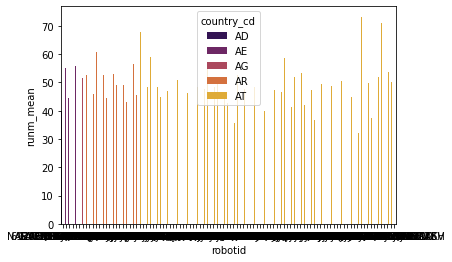

In [208]:
# Below is a histogram that shows the cleaning time for each robot color by country code:
# legend is not shown here, as it has massive amount of different time zones.

################## not finished running yet ###################
import seaborn as sns
my_palette = sns.color_palette('inferno', 5) # there are 84 countries from the rb table
sns.barplot(x="robotid", y="runm_mean", hue="country_cd", data=rb.iloc[:100,:], palette=my_palette)

The plot above shows the average cleaning time for 100 robots color by their country code. There is no obvious difference among the useage from the five countries as the bars fit in similar range by looking at this plot. To be able to see whether there are differences among all the countries, we can further calculate the average cleaning/charging/pausing time for each country.

Text(0, 0.5, 'Density')

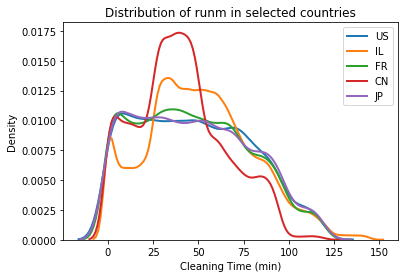

In [169]:
# Plot the distributions of runm from some countries:
us = robot.loc[robot['country_cd'] == 'US']
il = robot.loc[robot['country_cd'] == 'IL']
fr = robot.loc[robot['country_cd'] == 'FR']
cn = robot.loc[robot['country_cd'] == 'CN']
jp = robot.loc[robot['country_cd'] == 'JP']

# take a look at the distribution of cleaning time as an example:
import seaborn as sns
sns.distplot(us['runm'], hist=False, kde=True,kde_kws={'linewidth': 2}, label= 'US')
sns.distplot(il['runm'], hist=False, kde=True,kde_kws={'linewidth': 2}, label= 'IL')
sns.distplot(fr['runm'], hist=False, kde=True,kde_kws={'linewidth': 2}, label= 'FR')
sns.distplot(cn['runm'], hist=False, kde=True,kde_kws={'linewidth': 2}, label= 'CN')
sns.distplot(jp['runm'], hist=False, kde=True,kde_kws={'linewidth': 2}, label= 'JP')

plt.title('Distribution of runm in selected countries')
plt.xlabel('Cleaning Time (min)')
plt.ylabel('Density')


From the above plot, we see that the distributions of runm from the selected countries are all slightly positively skewed. Usually it indicates that <b>median</b> would be chosen over <b>mean</b>. But since the plots are not heavily skewed while overlapping (similar) to each other, we can still use <b>mean</b>. 

I will just use <b>mean</b> for "runm", "chrgm", and "pausem".

Therefore, the metric I will use is the average time spent on each activity (cleaning, charging, and paused) per country. I will compare the average time among the countries and visualize the extent of difference at the following steps.  

In [170]:
country = robot.groupby(['country_cd'])

# Noted that 72 entries don't have country code info recorded:
print(len(mission.loc[mission['robotid'] == 'QMJXZLREE88GULA1']['robotid']))
print(len(mission.loc[mission['robotid'] == 'Z9JJM7JRIGJYLER2']['robotid']))

47
25


/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


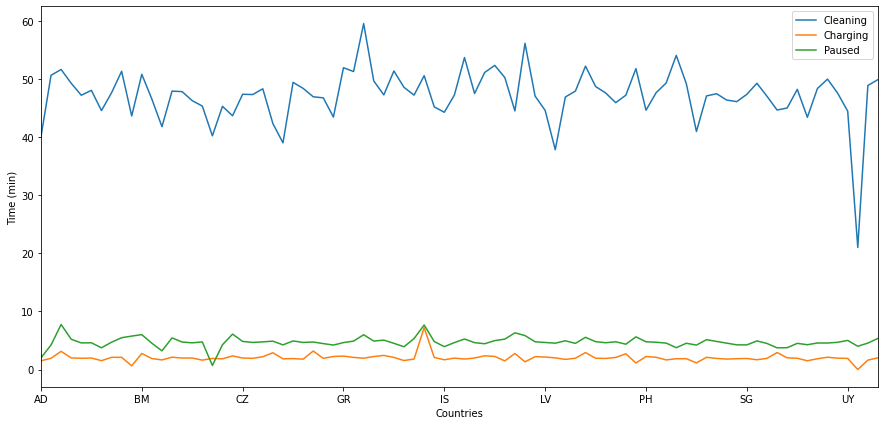

In [172]:
# plot the robot usage conditions in different countries:
fig, ax = plt.subplots(figsize=(15,7))
country.mean()['runm'].plot(ax=ax, label='Cleaning')
country.mean()['chrgm'].plot(ax=ax, label='Charging')
country.mean()['pausem'].plot(ax=ax, label='Paused')
plt.xlabel('Countries')
plt.ylabel('Time (min)')
plt.legend()

From the above plot, we obtained many useful information. In general, there are differences in robot usage in different countries:
* <b>The cleaning time varies the most among the 84 countries</b>. Customers in some countries use the robots for longer cleaning time that can be up to 60 minutes, while some use the robots for shorter chunk of time which can be as low as 21 minutes from the one robot example in Venezuela (with the country code = VE as shown below). One of the reason for time varies could be the housing types. For example, people in the U.S tend to live in bigger houses than people in HK where most of them live in smaller apartments. Other reasons could be socioeconomic status and others as mentioned above.
* <b>The charging time and paused time have smoother trends</b>, which also seems that there isn't an obvious relationship between the charging/paused time and cleaning time.

We may also look at the above info based on time zone, which shows similar results.
In conclusion, <b>there are geographic differences in robot usage</b> by looking at the above plots.

In [173]:
# we found Venezuela (VE) with the shortest cleaning time in the above plot:
country['runm'].describe()['min']

country_cd
AD     0.0
AE     0.0
AG     5.0
AR     0.0
AT     0.0
      ... 
US     0.0
UY     0.0
VE    21.0
VN     0.0
ZA     0.0
Name: min, Length: 84, dtype: float64

Now let's move on to explore the end status. Let's see if the time spent on cleaning, charging, and paused is associated with the end status. We do so by generating a multinomial logistic regression model and check the predictors' coefficients and p-values:

In [177]:
import statsmodels.api as sm

# extract runm, chrgm, pausem as predictors:
x = sm.add_constant(robot.iloc[:,3:6])
# extract the "outcome" column as dependent variables:
y = robot['outcome']


est = sm.MNLogit(y, x)
est = est.fit()
print(est.summary())

Optimization terminated successfully.
         Current function value: 0.812966
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:                outcome   No. Observations:               367679
Model:                        MNLogit   Df Residuals:                   367667
Method:                           MLE   Df Model:                            9
Date:                Wed, 05 Aug 2020   Pseudo R-squ.:                  0.1583
Time:                        10:23:27   Log-Likelihood:            -2.9891e+05
converged:                       True   LL-Null:                   -3.5511e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
 outcome=cncl       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             3.5453      0.027    131.005      0.000       3.492       3.598
runm             -0

We got many useful information from the summary table. First of all, we can see that outcome=bat is treated as the reference class. Then, we can start to talk about each outcome case separately:

1. When outcome=cncl as when the end status is cancel: 

    * cleaning and paused time are significantly associated with the outcome as their p values are smaller than 0.05, while charging time is not quite related to the outcome. 
    * Specifically, the coefficient for cleaning time (runm) = -0.0124. The number is log odss, which leads to an odds ratio that is smaller than 1 (exp(-0.0124) = 0.9876). It means that that increasing the cleaning time measurement by one minute will decrease the odds of a canceled status by 0.9876 times - in other words, <b>increasing the cleaning time will slightly decrease the probability of mission canceled</b>. 
    * Similarly, <b>increasing the paused time will slightly decrease the odds of a canceled status</b> by 0.9968 times. 0.9876 and 0.9968 are too close to 1, means almost no change to the probabilities. If we want to be really cautious, we may keep an eye on the association between cleaning time and canceled status, as 0.9876 is far from 1 than 0.9968.


2. When outcome = ok:
    * Cleaning, charging, and paused time are all significantly associated with the outcome status as the p-values are all really small.
    * Specifically, increasing the cleaning time will slightly decrease the odds of an ok status by 0.9881 (=exp(-0.0120)) times.
    * <b>increasing the charging time will decrease the odds of an ok status</b> by 0.9894 (=exp(-0.0107)) times.
    * <b>increasing the paused time will decrease the odds of an ok status</b> by 0.9900 times
    * to summarize, the three activities will all slightly decrease the the probability of an ok status, which seems a little strange, but there is no rush to state a conclusion yet. We may need further analysis to prove or against it. 
    
    
3. When outcome = stuck:
    * Only cleaning time is significantly associated with the stuck status.
    * <b>increasing the cleaning time will decrease the odds of an stuck status</b> by 0.7274 times.
    
    
To summarize the above information, it seems like the longer the robot can run on cleaning, it is less likely to get a "canceled" or "stuck" status. On the other hand, we may speculate that <b>the longer the robot spent on charging and paused during a mission, it is less likely to get an "ok" result </b>. 


What we can think of is that <b>if the robot has better performance and working efficiency that can clean for longer time or finish the mission quicker, it is less possible for it to encounter the lack of battery or a "stuck" status, and the users will be happier as the robot successfully completed cleaning the space and returned to the dock</b>. This conclusion is understandable by our life experience and existing knowledge, but now we have the data to support it! 


*** 
In the next step, I would like to see how the end status varies among the countries and time zones. If a certain status occurs more frequently at some regions over others, we know what to improve for the robots being sold to the region during the product development and manufacturing process:

In [178]:
country['outcome'].value_counts()

country_cd  outcome
AD          ok          36
            cncl        14
AE          ok         136
            cncl        63
            stuck        6
                      ... 
VN          bat          1
ZA          ok          56
            cncl        12
            stuck        6
            bat          2
Name: outcome, Length: 316, dtype: int64

In [179]:
values = country['outcome'].value_counts().keys().tolist()
count = country['outcome'].value_counts().tolist()

In [180]:
values = pd.DataFrame(values)
values['count'] = count
values.columns = ['Country', 'Outcome','Count']

# Count of each end status per Country:
values.head()

,Country,Outcome,Count
0,AD,ok,36
1,AD,cncl,14
2,AE,ok,136
3,AE,cncl,63
4,AE,stuck,6


In [181]:
frequency = values.groupby(['Country','Outcome']).agg({'Count': 'sum'})
frequency = frequency.groupby(level=0).apply(lambda x:  100*x / x.sum())
frequency = frequency.rename(columns={'Count': '%'})
# Frequency of each end status per Country:
frequency.head()

%
Country Outcome           
AD      cncl     28.000000
        ok       72.000000
AE      bat       2.380952
        cncl     30.000000
        ok       64.761905

In [182]:
# slice all rows with different outcome status:
idx = pd.IndexSlice
ok = frequency.loc[idx[:, 'ok'], :].reset_index()
cncl = frequency.loc[idx[:, 'cncl'], :].reset_index()
stuck = frequency.loc[idx[:, 'stuck'], :].reset_index()
bat = frequency.loc[idx[:, 'bat'], :].reset_index()
ok.head()

,Country,Outcome,%
0,AD,ok,72.000000
1,AE,ok,64.761905
2,AG,ok,37.500000
3,AR,ok,60.803059
4,AT,ok,61.678348


,%
count,84.000000
mean,62.297238
std,8.178176
min,37.500000
25%,60.000000
50%,61.963617
75%,64.803656
max,100.000000


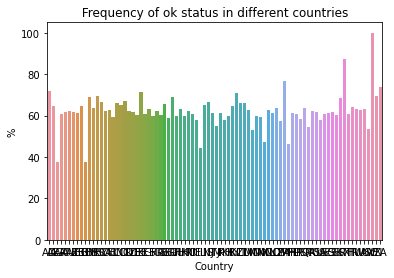

In [184]:
# plot the frequency of "ok" status in different countries:
sns.barplot(x='Country', y='%', data=ok)
plt.title(' Frequency of ok status in different countries ')
ok.describe()

The above plot is an example of the frequency of the end status in different countries. We saw some countries have relatively low or high frequencies. To better visualize and distinguish the countries based on the status, we may generate another column with three classes, that the frequencies (%) that are less than 25% equal 0, between 25% and 75% equal 1, and greater than 75% equal 2. We could then plot the world map color based on the three levels:

In [185]:
x1 = pd.qcut(ok['%'], q=[0, 0.25, 0.75, 1], labels=[0,1,2])
ok['Recode'] = x1

x2 = pd.qcut(cncl['%'], q=[0, 0.25, 0.75, 1], labels=[0,1,2])
cncl['Recode'] = x2

x3 = pd.qcut(stuck['%'], q=[0, 0.25, 0.75, 1], labels=[0,1,2])
stuck['Recode'] = x3

x4 = pd.qcut(bat['%'], q=[0, 0.25, 0.75, 1], labels=[0,1,2])
bat['Recode'] = x4

Text(0.5, 1.0, 'Global Distribution of Robots Successfully Completing Cleaning (ok)')

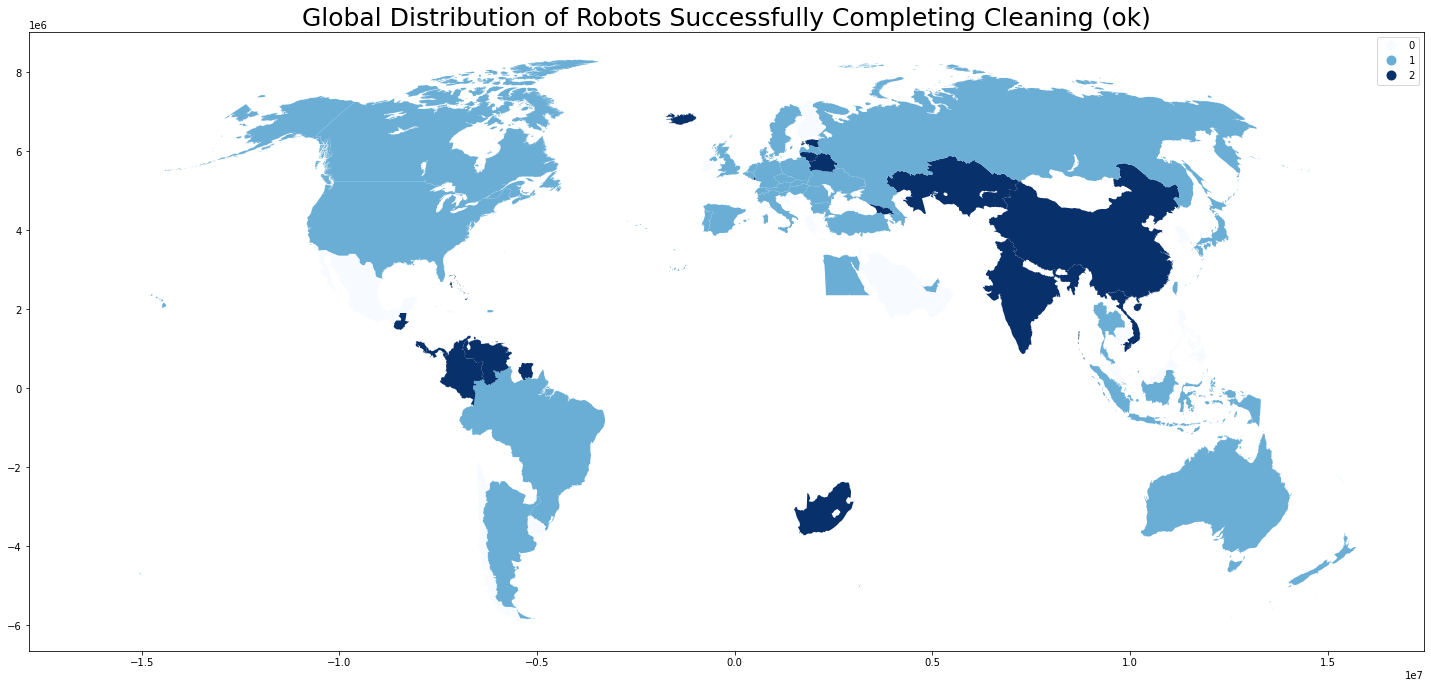

In [187]:
# plot the world map of countries colored by the level of end status, starting with the "ok" status:
import os
import geopandas as gpd
 
# create a geo dataframe:
shapefile = os.path.expanduser('ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp')
gdf = gpd.read_file(shapefile)[['ISO_A2', 'geometry']].to_crs('+proj=robin')
merged = gdf.merge(ok, left_on='ISO_A2', right_on='Country')
merged.plot(column='Recode', figsize=(25, 20), k=3, legend=True, cmap= 'Blues')
plt.title('Global Distribution of Robots Successfully Completing Cleaning (ok)',fontsize=25)

Text(0.5, 1.0, 'Global Distribution of Missions being Cancelled (cncl)')

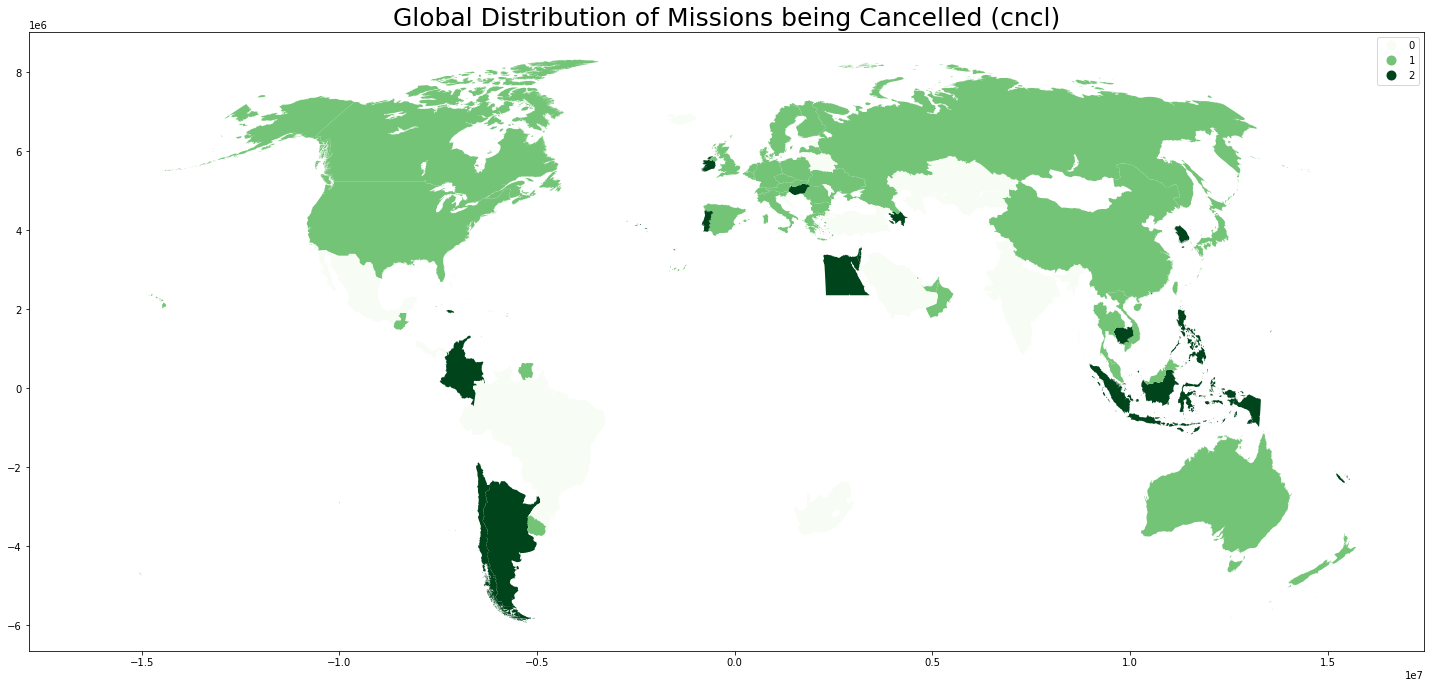

In [191]:
# Next is the world map plot showing the frequency of "cancelled" Status of Robot usage in Different Countries:
merged1 = gdf.merge(cncl, left_on='ISO_A2', right_on='Country')
merged1.plot(column='Recode', figsize=(25, 20), k=3, legend=True, cmap= 'Greens')
plt.title('Global Distribution of Missions being Cancelled (cncl)',fontsize=25)

Text(0.5, 1.0, 'Global Distribution of Robots Getting Stuck (stuck)')

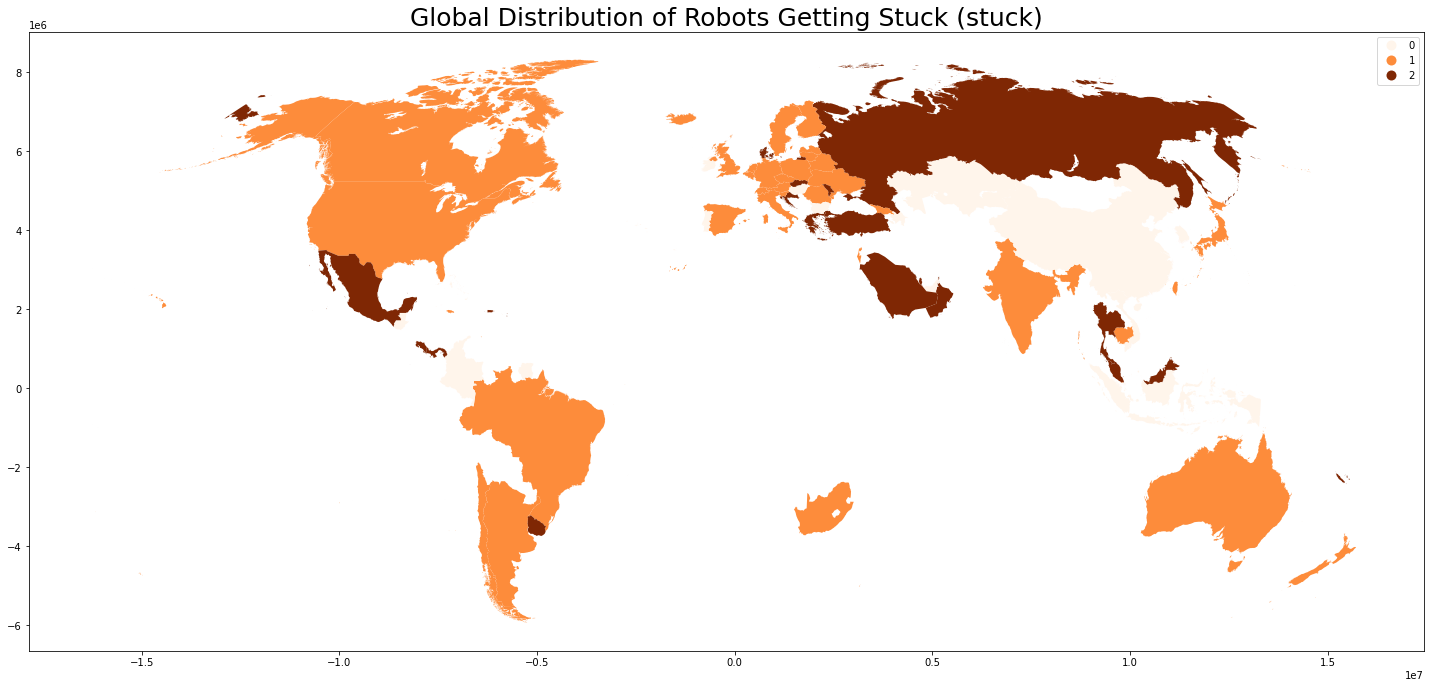

In [192]:
merged2 = gdf.merge(stuck, left_on='ISO_A2', right_on='Country')
merged2.plot(column='Recode', figsize=(25, 20), k=3, legend=True, cmap= 'Oranges')
plt.title('Global Distribution of Robots Getting Stuck (stuck)',fontsize=25)

Text(0.5, 1.0, 'Global Distribution of Battery too low (bat)')

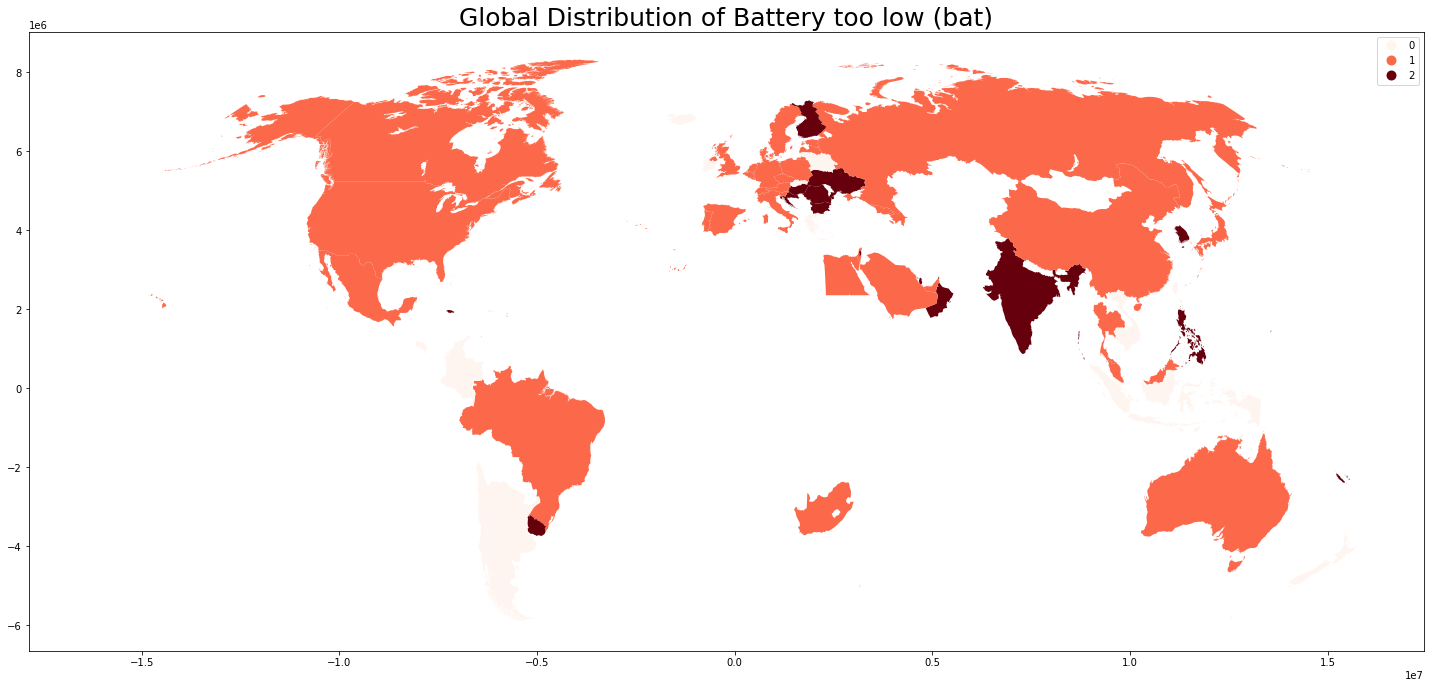

In [193]:
merged3 = gdf.merge(bat, left_on='ISO_A2', right_on='Country')
merged3.plot(column='Recode', figsize=(25, 20), k=3, legend=True, cmap= 'Reds')
plt.title('Global Distribution of Battery too low (bat)',fontsize=25)

The above four world maps provide the corresponding distributions of four ending status globally. The lightest color indicates less probability of the status that may happen, and vice versa. Take the above map as an example, the regions in darker red are the places with the most frequent situation where the robot's battery grew too low for it to return to the dock, and these regions are the target we would like to develop the robots for. We will be mainly focusing on the darkest regions from the last three maps that are related to cncl, stuck, and bat.

1. Specifically, the regions with the darkest color (e.g., India and Philippines) in the map related to battery being too low indicate a red flag that the situation of robots' battery growing too low for it to return to the dock is more frequently than other regions. <b>So it suggests us improving the battery or power management to reduce this outcome for the robots sold in the darkest areas</b>.

2. Similarly, the regions with the darkest color (e.g., Russia and Mexico) in the map related to robots getting stuck indicate a red flag that the robots got stuck more frequently than other regions - it could be because that the building structures tend to be more complicated in there. Therefore, we may need to <b>improve the navigation algorithms for robots sold in the darkest areas where they got stuck more often </b>.

3. The map related to missions being canceled maybe a slightly different case. The darker the color, the more often the users tended to cancel the mission, e.g., Argentina. We need to do more research in these regions to see what may influence their user experience/behavior, and if they are less satisfied by using the robots. Other than being interrupted by other events, one of the reasons a user decides to cancel the mission could be because that the robot is not workign as functionally as they expected, or the user just cancelled the missino when the robot got stuck somewhere. We could then improve the robot's performance accordingly by improving the hardware design, navigation lgorithms, etc. 

4. The very first map is related to robots Successfully Completing Cleaning. The darker the color, the more frequently the missions can be completed successfully. Instead, now we should take a look at the regions in the lightest (white) color. We notice the lighter regions in the first map tend to be darker in the following three maps. So by analyzing the three problematic situations showing in last three maps, we may find some ways to increase the proportion of missions being completed succesfully and improve user engagement.

*** 
Now let's see the time between consecutive missions for each robot:

In [194]:
# check the data types in the mission table:
mission.dtypes

robotid     object
datetime    object
nmssn        int64
runm         int64
chrgm        int64
pausem       int64
outcome     object
dtype: object

In [195]:
# convert the datetime column from object to datetime:
mission['datetime'] = pd.to_datetime(mission['datetime'])

In [196]:
# calculate the time difference between consecutive missions for each robot
mission['time_diff'] = mission.groupby(['robotid'])['datetime'].diff().fillna(0)
mission.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Passing integers to fillna is deprecated, will raise a TypeError in a future version.  To retain the old behavior, pass pd.Timedelta(seconds=n) instead.
  


,nmssn,runm,chrgm,pausem,time_diff
count,367679.000000,367679.000000,367679.000000,367679.000000,367679
mean,73.258984,48.906383,5.152772,6.231351,4 days 06:50:25.413599
std,35.749076,29.819507,8.364238,8.202553,9 days 17:47:12.832962
min,1.000000,0.000000,0.000000,0.000000,-1 days +00:09:34
25%,47.000000,27.000000,0.000000,0.000000,0 days 07:48:59
50%,71.000000,47.000000,0.000000,1.000000,1 days 10:32:16
75%,95.000000,70.000000,11.000000,12.000000,4 days 09:09:45
max,248.000000,144.000000,30.000000,40.000000,427 days 03:19:09


We realized that the minimum time_difference is <b>-1 days +00:09:34</b> as shown above. And we might have more than one negative time differences. It means that some data input could be wrong because the duration should be positive if nmssn (mission number) is consecutive in a positive direction. Let's see what happened:

In [197]:
mission[mission.time_diff == mission.time_diff.min()] # we see that it is at index 248466

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,time_diff
248466,OBWYZDT6K694O6U9,2016-11-14 05:06:07,117,48,7,6,ok,-1 days +00:09:34


In [198]:
# Let's see how many time_diff is negative:
mission[mission.time_diff < pd.to_timedelta(0)]

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,time_diff
33,006Q50H53GXM7BYO,2017-05-03 12:52:20,45,73,0,10,ok,-1 days +12:02:37
36,006Q50H53GXM7BYO,2017-05-16 08:44:00,48,52,12,8,cncl,-1 days +16:24:10
56,00EZQ4MZ6JLQPJK6,2016-07-07 06:58:08,81,82,0,0,cncl,-1 days +23:56:38
65,00EZQ4MZ6JLQPJK6,2016-07-24 07:19:01,94,38,0,8,ok,-1 days +23:41:36
116,00KI1HU70Y15Z10K,2017-06-08 06:19:23,100,55,13,0,cncl,-1 days +13:18:36
...,...,...,...,...,...,...,...,...
367663,ZZUJVI3GXRLIG0MT,2017-11-30 10:15:05,65,15,0,3,cncl,-1 days +19:42:17
367665,ZZUJVI3GXRLIG0MT,2017-11-30 06:26:47,67,107,0,18,ok,-1 days +15:26:47
367667,ZZUJVI3GXRLIG0MT,2017-12-01 07:55:08,69,37,0,6,cncl,-1 days +16:17:11
367669,ZZUJVI3GXRLIG0MT,2017-12-02 10:33:41,71,56,13,10,cncl,-1 days +21:20:15


From the above table, we found 50094 missions that have a negative time duration.

In [199]:
prob = 50094/367679
print('The proportion of missions that have a negative time gap from the previous one:',f"{prob:.2%}")

The proportion of missions that have a negative time gap from the previous one: 13.62%


In [200]:
# Let's check the rows around index 248466 to  why there are negative time gaps:
mission.iloc[248462:248470,:]

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,time_diff
248462,OBWYZDT6K694O6U9,2016-11-15 02:22:19,113,34,0,4,cncl,0 days 12:09:13
248463,OBWYZDT6K694O6U9,2016-11-14 10:45:06,114,56,0,0,ok,-1 days +08:22:47
248464,OBWYZDT6K694O6U9,2016-11-15 03:13:47,115,0,0,0,cncl,0 days 16:28:41
248465,OBWYZDT6K694O6U9,2016-11-15 04:56:33,116,30,13,9,ok,0 days 01:42:46
248466,OBWYZDT6K694O6U9,2016-11-14 05:06:07,117,48,7,6,ok,-1 days +00:09:34
248467,OBWYZDT6K694O6U9,2016-11-15 19:29:22,118,62,9,0,cncl,1 days 14:23:15
248468,OBWYZDT6K694O6U9,2016-11-15 15:49:50,119,1,0,1,ok,-1 days +20:20:28
248469,OBWYZDT6K694O6U9,2016-11-18 00:06:54,121,48,0,10,cncl,2 days 08:17:04


From the example table above, we can see that the time differences between mission 113 and 114, 116 and 117, 118 and 119 are negative. It is because the latter mission has the datetime that shows it happened earlier than the former mission. <b>There might be some problems with the datetime submission and/or mission incremental function. And it happened at least 50094 times (we're unsure about their subsequent rows) </b>. 

In [202]:
# It also seems suspicious when time_difference = 427 days. Let's check it out:
print('The mission with the longest time gap from the previous one:\n', mission[mission.time_diff == mission.time_diff.max()]) # this is at index 202710
print('\n The first date in the report: \n', mission['datetime'].min())
print('\n The last date in the report: \n', mission['datetime'].max())
mission.iloc[202708:202712,:]

The mission with the longest time gap from the previous one:
                  robotid            datetime  nmssn  runm  chrgm  pausem  \
202710  JTAA77QRRKZGFPDV 2017-09-13 06:03:19     24    44      0       0   

       outcome         time_diff  
202710    cncl 427 days 03:19:09  

 The first date in the report: 
 2015-12-31 16:56:47

 The last date in the report: 
 2017-12-29 08:53:17


,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,time_diff
202708,JTA87JHD7K5ELCN2,2017-08-05 22:18:54,153,60,19,17,ok,2 days 02:55:39
202709,JTAA77QRRKZGFPDV,2016-07-13 02:44:10,23,101,0,0,ok,0 days 00:00:00
202710,JTAA77QRRKZGFPDV,2017-09-13 06:03:19,24,44,0,0,cncl,427 days 03:19:09
202711,JTAV9112M6Q73EFC,2016-04-06 13:26:45,72,67,0,33,ok,0 days 00:00:00


In [203]:
robot.iloc[202709:202711,:]

,robotid,datetime,nmssn,runm,chrgm,pausem,outcome,country_cd,timezone
202709,JTAA77QRRKZGFPDV,2016-07-13 02:44:10,23,101,0,0,ok,IL,Asia/Jerusalem
202710,JTAA77QRRKZGFPDV,2017-09-13 06:03:19,24,44,0,0,cncl,IL,Asia/Jerusalem


We see that the robot <b>JTAA77QRRKZGFPDV</b> has the last recorded mission occuring over a year period after the previous one - and the last use was canceled. It seems like the customer of that robot might not be in favor of using this product, if there wasn't any mission after the 24th in 2017. However, the robot spent 101 minutes on cleaning during the 23rd mission, and it was way longer than the average of the cleaning time (~48 mins). The cleaning time spent on the last mission was close to the average as well. 

This customer is at IL, Israel. If interested specifically, we may do some further research or contact the customer to check what happened to his/her user experience.

***
At the end, we can apply a linear regression to see if there's any relationship between the time difference and other features of robot behavior:

In [205]:
import statsmodels.formula.api as smf

mission['time_diff_seconds'] = mission['time_diff'].dt.total_seconds()
mod = smf.ols('time_diff_seconds ~ runm + chrgm + pausem', data=mission).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      time_diff_seconds   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     56.66
Date:                Wed, 05 Aug 2020   Prob (F-statistic):           1.32e-36
Time:                        10:27:49   Log-Likelihood:            -5.5379e+06
No. Observations:              367679   AIC:                         1.108e+07
Df Residuals:                  367675   BIC:                         1.108e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.407e+05   2711.079    125.686      0.000    3.35e+05    3.46e+05
runm         484.4465     49.089      9.869      0.000     388.234     580.659
chrgm        673.4006    180.243      3.736      0.000     320.129    1026.672
pausem       372.0296    183.761      2.025      0.043      11.863     732.196
==============================================================================
Omnibus:                   548233.526   Durbin-Watson:                   1.366
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        403876278.926
Skew:                           9.020   Prob(JB):                         0.00
Kurtosis:                     164.361   Cond. No.                         113.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the above table, we saw that cleaning time (runm), charging time (chrgm), and paused time (pausem) are all significantlly associated with the time difference, as their p-values are all smaller than 0.05. It turns out that when the time spent on each three of the activities increases, the time gap between each mission increases as well. 

* Specifically, <b>increasing charging time may increase the time gap the most</b>, as its coefficient is the largest compared to other activities. We can guess that the longer time the robot needed to be fully charged, the longer time users would wait for it to be able to start the next mission. <b>If we want the users to use it more often, we may improve the battery to be charged faster, as well as getting the battery to be drained out more slowly</b>.

* Similarly, <b>the longer time the robots spent on cleaning, the room got cleaner and the users could wait longer to start the next mission</b>.

* And <b>the longer time the robots got stuck somewhere, the users may become less confident about it and use it less frequently</b>. However, as this prediction sounds scary, the coefficient of pausem is the smallest among  the three so we don't really need to start to worry about it until we improve the first case.


This conclusion may be affected by the negative time gap though. It means if a data input related to the negative time gap was due to a mistake, then the calculated time gap of this row and the subsequent row will be wrong. 

In [206]:
# Let's try the linear model again quickly by simply eliminating the negative time gap;
# Noted that the subsequent rows of the ones with negative time gaps are still included in this trial:
df = mission[mission.time_diff_seconds > 0]
mod1 = smf.ols('time_diff_seconds ~ runm + chrgm + pausem', data=df).fit()
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      time_diff_seconds   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     49.27
Date:                Wed, 05 Aug 2020   Prob (F-statistic):           7.99e-32
Time:                        10:27:56   Log-Likelihood:            -4.6560e+06
No. Observations:              307752   AIC:                         9.312e+06
Df Residuals:                  307748   BIC:                         9.312e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.144e+05   3175.885    130.479      0.000    4.08e+05    4.21e+05
runm         523.4214     57.357      9.126      0.000     411.002     635.840
chrgm        768.1475    210.376      3.651      0.000     355.816    1180.479
pausem       397.6925    214.452      1.854      0.064     -22.628     818.013
==============================================================================
Omnibus:                   445579.387   Durbin-Watson:                   1.346
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        269814879.983
Skew:                           8.566   Prob(JB):                         0.00
Kurtosis:                     147.042   Cond. No.                         114.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This time, charging time is still the feature that increases the time gap the most, while paused time is not significantlly associated with the time gap.